# AI_campus_ProstateSeg 
# Module 2: Data Visualization of Images and Masks
### PANDA: Prostate cANcer graDe Assessment (PANDA) Challenge

In this notebook, we will visualize a subset of the PANDA dataset, including images and their corresponding masks. We will also characterize the masks for the distribution of various classes, dimensionality, etc. These images and mask pairs are from the Radboud subset of the data. 

## 1. Import the necessary packages

In [1]:
import os
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import panda_utils as putil

from PIL import Image
from typing import List, Union, Optional, Dict

## 2. Define folder and sub-folder directory names

In [25]:
ROOT_FOLDER = "sample_data"
IMAGE_SUBFOLDER = "train_images"
MASK_SUBFOLDER = "train_label_masks"

image_dir = os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER)
mask_dir = os.path.join(ROOT_FOLDER, MASK_SUBFOLDER)

## 3. Create list of image and mask files and print out all contents

In [3]:
image_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(image_dir))))
mask_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(mask_dir))))

In [4]:
image_files

['0018ae58b01bdadc8e347995b69f99aa.tiff',
 '004dd32d9cd167d9cc31c13b704498af.tiff',
 '0068d4c7529e34fd4c9da863ce01a161.tiff',
 '006f6aa35a78965c92fffd1fbd53a058.tiff',
 '007433133235efc27a39f11df6940829.tiff',
 '0076bcb66e46fb485f5ba432b9a1fe8a.tiff',
 '008069b542b0439ed69b194674051964.tiff',
 '00928370e2dfeb8a507667ef1d4efcbb.tiff',
 '00951a7fad040bf7e90f32e81fc0746f.tiff',
 '00a26aaa82c959624d90dfb69fcf259c.tiff']

In [5]:
mask_files

['0018ae58b01bdadc8e347995b69f99aa_mask.tiff',
 '004dd32d9cd167d9cc31c13b704498af_mask.tiff',
 '0068d4c7529e34fd4c9da863ce01a161_mask.tiff',
 '006f6aa35a78965c92fffd1fbd53a058_mask.tiff',
 '007433133235efc27a39f11df6940829_mask.tiff',
 '0076bcb66e46fb485f5ba432b9a1fe8a_mask.tiff',
 '008069b542b0439ed69b194674051964_mask.tiff',
 '00928370e2dfeb8a507667ef1d4efcbb_mask.tiff',
 '00951a7fad040bf7e90f32e81fc0746f_mask.tiff',
 '00a26aaa82c959624d90dfb69fcf259c_mask.tiff']

## 4. Run functions from module 1 to validate the data

Verifies if every image file in the provided image directory has a corresponding mask file in the mask directory.

In [6]:
putil.verify_pair_match(image_dir = image_dir,
                        mask_dir = mask_dir)

True

Verifies that each image and mask pair have the same dimensionality

In [7]:
putil.verify_dim_match(image_dir = image_dir,
                       mask_dir = mask_dir,
                       root_folder = ROOT_FOLDER,
                       image_subfolder = IMAGE_SUBFOLDER,
                       mask_subfolder = MASK_SUBFOLDER)

True

Validate all masks in the directory

In [8]:
putil.validate_mask_dir(mask_dir = mask_dir,
                        root_folder = ROOT_FOLDER,
                        mask_subfolder = MASK_SUBFOLDER)

True

## 5. Load and print out the dimensions of each of the images contained in the image folder

In [9]:
for image_file in image_files:
    img = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_file))
    print(img.shape)

(25344, 5888, 3)
(22528, 8192, 3)
(10496, 6912, 3)
(7680, 2048, 3)
(24320, 9472, 3)
(14848, 11776, 3)
(8704, 23808, 3)
(36352, 10752, 3)
(8192, 11520, 3)
(20736, 18688, 3)


## 6. Load and print out the dimensions of each of the masks contained in the mask folder

In [10]:
for mask_file in mask_files:
    mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
    print(mask.shape)

(25344, 5888, 3)
(22528, 8192, 3)
(10496, 6912, 3)
(7680, 2048, 3)
(24320, 9472, 3)
(14848, 11776, 3)
(8704, 23808, 3)
(36352, 10752, 3)
(8192, 11520, 3)
(20736, 18688, 3)


## 7. Write function to validate and characterize masks. Mine single channel from mask that can be used as the official segmentation mask

In [11]:
def characterize_three_channel_mask(mask: np.ndarray) -> str:
    
    """
    Since the PANDA dataset masks have 3 channels, this is a function to
    validate and characterize an input mask. Only one of the three channels
    of the mask could be effectively used as the official mask of the corresponding
    image. 
    
    Parameters:
    ----------
    mask: np.ndarray
        Input three-channel mask with integer labels possibly ranging from 0-5
        across one or all channels
    
    For the Radboud study of the PANDA dataset:
        0: background (non tissue) or unknown
        1: stroma (connective tissue, non-epithelium tissue)
        2: healthy (benign) epithelium
        3: cancerous epithelium (Gleason 3)
        4: cancerous epithelium (Gleason 4)
        5: cancerous epithelium (Gleason 5)
    
    Returns:
    -------
    str
        Characterizes the mask according to the following possible cases
    """
    
    # Verify that the mask to validate contains 3 channels
    assert isinstance(mask, np.ndarray)
    assert mask.shape[2] == 3
    
    # Extract first, second, and third channels from the mask
    first = mask[:, :, 0]
    second = mask[:, :, 1]
    third = mask[:, :, 2]
    
    first_sum = first.sum()
    second_sum = second.sum()
    third_sum = third.sum()
    
    # Ensure that the mask only contains 0s or positive integers
    assert first_sum >= 0 and second_sum >= 0 and third_sum >= 0
    
    # Case 1: The mask indicates all background (contains only 0s)
    # If all entries in all channels are 0, all channels will sum to 0
    
    if (first_sum + second_sum + third_sum) == 0:
        return "Case 1: The mask indicates all background, any of channels 0, 1, or 2 can be used"
    
    # Case 2: The mask indicates non-zero signal and only one of the three channels
    # is designated to express the non-zero signal
    # Exactly one of the channels will sum to a number greater than 0
    # While the other two channels will each sum to 0
    
    if first_sum > 0 and (second_sum + third_sum == 0):
        return "Case 2: The mask indicates non-zero signal, only channel 0 is designated to express it"
    if second_sum > 0 and (first_sum + third_sum == 0):
        return "Case 2: The mask indicates non-zero signal, only channel 1 is designated to express it"
    if third_sum > 0 and (first_sum + second_sum == 0):
        return "Case 2: The mask indicates non-zero signal, only channel 2 is designated to express it"
    
    # Case 3: The mask indicates non-zero signal and two channels are designated to
    # express that non-zero signal. So two of the three channels must sum to a number 
    # greater than 0 and both of them should be identical, while the remaining channel
    # should sum to 0
    
    if third_sum == 0 and first_sum > 0 and second_sum > 0 and np.all(first == second):
        return "Case 3: The mask indicates non-zero signal, channels 0 and 1 are designated to express it, they are identical and can be used interchangeably"
    if second_sum == 0 and first_sum > 0 and third_sum > 0 and np.all(first == third):
        return "Case 3: The mask indicates non-zero signal, channels 0 and 2 are designated to express it, they are identical and can be used interchangeably"
    if first_sum == 0 and second_sum > 0 and third_sum > 0 and np.all(second == third):
        return "Case 3: The mask indicates non-zero signal, channels 1 and 2 are designated to express it, they are identical and can be used interchangeably"
    
    # Case 4: 
    # The mask indicates non-zero signal and all of the three channels are designated
    # to express that non-zero signal. So each of the three channels must sum to a number
    # greater than 0 and all of them must be identical
    
    if all([first_sum > 0, second_sum > 0, third_sum > 0]) and (first_sum == second_sum == third_sum) and np.all(first == second) and np.all(second == third):
        return "Case 4: The mask indicates non-zero signal, and each of channels 0, 1, and 2 express it, they are all identical and any of them can be used"
    
    return "None of the cases hold True, inspect mask"

Apply function to all masks in the folder in order to characterize them

In [12]:
for mask_file in mask_files:
    mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
    print(characterize_three_channel_mask(mask))

Case 2: The mask indicates non-zero signal, only channel 0 is designated to express it
Case 2: The mask indicates non-zero signal, only channel 0 is designated to express it
Case 2: The mask indicates non-zero signal, only channel 0 is designated to express it
Case 2: The mask indicates non-zero signal, only channel 0 is designated to express it
Case 2: The mask indicates non-zero signal, only channel 0 is designated to express it
Case 2: The mask indicates non-zero signal, only channel 0 is designated to express it
Case 2: The mask indicates non-zero signal, only channel 0 is designated to express it
Case 2: The mask indicates non-zero signal, only channel 0 is designated to express it
Case 2: The mask indicates non-zero signal, only channel 0 is designated to express it
Case 2: The mask indicates non-zero signal, only channel 0 is designated to express it


## 8. Find out the signal content of each of the masks. Print out the percentage of pixels that indicate any signal at all (number of entries in mask where value is more than 0)

In [13]:
def mask_signal_ratio(mask: np.ndarray,
                      channel_idx: int = 0) -> float:
    
    """
    Calculate the number of pixels in mask that
    are more than 0, and hence, indicate a signal
    as a percentage of the total number of pixels
    
    Parameters:
    ----------
    
    mask: np.ndarray
        Input mask
    
    channel_idx: int (default = 0)
        In case of a three-channel mask, the channel id that can be used
        as the official mask 
    
    Returns:
    ---------
    
    float
        The percentage of pixels in the mask
        that contain a signal, i.e. a value 
        greater than 0
    """
    
    if len(mask.shape) == 3 and mask.shape[2] == 3:
        mask = mask[:, :, channel_idx]
        
    assert len(mask.shape) == 2
    
    return (mask > 0).sum()/mask.size

In [14]:
for mask_file in mask_files:
    mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
    print(f"Signal to background ratio of mask {mask_file}: {round(mask_signal_ratio(mask),2)}")

Signal to background ratio of mask 0018ae58b01bdadc8e347995b69f99aa_mask.tiff: 0.21
Signal to background ratio of mask 004dd32d9cd167d9cc31c13b704498af_mask.tiff: 0.17
Signal to background ratio of mask 0068d4c7529e34fd4c9da863ce01a161_mask.tiff: 0.15
Signal to background ratio of mask 006f6aa35a78965c92fffd1fbd53a058_mask.tiff: 0.43
Signal to background ratio of mask 007433133235efc27a39f11df6940829_mask.tiff: 0.09
Signal to background ratio of mask 0076bcb66e46fb485f5ba432b9a1fe8a_mask.tiff: 0.2
Signal to background ratio of mask 008069b542b0439ed69b194674051964_mask.tiff: 0.15
Signal to background ratio of mask 00928370e2dfeb8a507667ef1d4efcbb_mask.tiff: 0.2
Signal to background ratio of mask 00951a7fad040bf7e90f32e81fc0746f_mask.tiff: 0.33
Signal to background ratio of mask 00a26aaa82c959624d90dfb69fcf259c_mask.tiff: 0.06


### 9. Find out which classes are represented in the mask. The classes could have varying levels of presence or frequency

In [15]:
def enlist_class_presence(mask: np.ndarray,
                          channel_idx: int = 0) -> np.ndarray:
    """
    Enlist the classes present in the mask, 
    i.e. the types of unique integers present
    
    Parameters:
    ----------
    mask: np.ndarray
        Input mask
    
    channel_idx: int (default = 0)
        In case of a three-channel mask, the channel id that can be used
        as the official mask
    
    Returns:
    --------
    np.ndarray
        An array of class labels (integer indexes) present in the mask
    """
    
    if len(mask.shape) == 3 and mask.shape[2] == 3:
        mask = mask[:, :, channel_idx]
    
    assert len(mask.shape) == 2
    
    return np.unique(mask)

In [16]:
for mask_file in mask_files:
    mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
    print(f"Class presence of mask {mask_file} : {enlist_class_presence(mask)}")

Class presence of mask 0018ae58b01bdadc8e347995b69f99aa_mask.tiff : [0 1 2 4]
Class presence of mask 004dd32d9cd167d9cc31c13b704498af_mask.tiff : [0 1 2]
Class presence of mask 0068d4c7529e34fd4c9da863ce01a161_mask.tiff : [0 1 2 3]
Class presence of mask 006f6aa35a78965c92fffd1fbd53a058_mask.tiff : [0 1 3 4]
Class presence of mask 007433133235efc27a39f11df6940829_mask.tiff : [0 1 2]
Class presence of mask 0076bcb66e46fb485f5ba432b9a1fe8a_mask.tiff : [0 1 2 3 4]
Class presence of mask 008069b542b0439ed69b194674051964_mask.tiff : [0 1 2 4]
Class presence of mask 00928370e2dfeb8a507667ef1d4efcbb_mask.tiff : [0 1 2 4 5]
Class presence of mask 00951a7fad040bf7e90f32e81fc0746f_mask.tiff : [0 1 2 3]
Class presence of mask 00a26aaa82c959624d90dfb69fcf259c_mask.tiff : [0 1 2 4]


## 10. Summarize the class distribution in each of the masks

In [59]:
def summarize_class_distribution(mask: np.ndarray,
                                 channel_idx: int = 0) -> Dict[int, float]:
    """
    Summarize the percentage distribution of 
    different classes present in the mask. 
    
    Parameters:
    ----------
    mask: np.ndarray
        Input mask
    
    channel_idx: int (default = 0)
        In case of a three-channel mask, the channel id that
        can be used as the official mask
    
    Returns:
    --------
    Dict[int, float]
        A dictionary mapping each of the present class labels
        to its percentage frequency in the mask
    """
    
    if len(mask.shape) == 3 and mask.shape[2] == 3:
        mask = mask[:, :, channel_idx]
    
    assert len(mask.shape) == 2
    
    dist_dict = dict()
    avail_classes = np.unique(mask)
    
    for c in avail_classes:
        dist_dict[c] = round((mask == c).sum()/mask.size, 2)
    
    assert 0.95 < sum(dist_dict.values()) <= 1.01
    
    return dist_dict

In [60]:
for mask_file in mask_files:
    mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
    print(f"Class distribution of mask {mask_file} : {summarize_class_distribution(mask)}")

Class distribution of mask 0018ae58b01bdadc8e347995b69f99aa_mask.tiff : {0: 0.79, 1: 0.16, 2: 0.0, 4: 0.05}
Class distribution of mask 004dd32d9cd167d9cc31c13b704498af_mask.tiff : {0: 0.83, 1: 0.16, 2: 0.01}
Class distribution of mask 0068d4c7529e34fd4c9da863ce01a161_mask.tiff : {0: 0.85, 1: 0.14, 2: 0.01, 3: 0.0}
Class distribution of mask 006f6aa35a78965c92fffd1fbd53a058_mask.tiff : {0: 0.57, 1: 0.31, 3: 0.02, 4: 0.1}
Class distribution of mask 007433133235efc27a39f11df6940829_mask.tiff : {0: 0.91, 1: 0.08, 2: 0.0}
Class distribution of mask 0076bcb66e46fb485f5ba432b9a1fe8a_mask.tiff : {0: 0.8, 1: 0.18, 2: 0.0, 3: 0.0, 4: 0.02}
Class distribution of mask 008069b542b0439ed69b194674051964_mask.tiff : {0: 0.85, 1: 0.11, 2: 0.02, 4: 0.02}
Class distribution of mask 00928370e2dfeb8a507667ef1d4efcbb_mask.tiff : {0: 0.8, 1: 0.14, 2: 0.01, 4: 0.01, 5: 0.04}
Class distribution of mask 00951a7fad040bf7e90f32e81fc0746f_mask.tiff : {0: 0.67, 1: 0.32, 2: 0.0, 3: 0.01}
Class distribution of mask 0

## 11. Plot the distribution of classes in each of the masks histogrammatically

In [61]:
def dict_to_histogram(class_dict: dict,
                      whole_classes = [0, 1, 2, 3, 4, 5]):
    """
    Plot histogram of distribution of classes
    """
    for c in whole_classes:
        if c not in class_dict:
            class_dict[c] = 0.0
    
    keys = list(class_dict.keys())
    values = list(class_dict.values())
    plt.bar(keys, values)
    plt.xlabel("Class", fontsize = 20)
    plt.ylabel("Percentage Composition in Mask")
    plt.title("Distribution of Classes in Mask")
    plt.show()

Class distribution histogram of mask: 0018ae58b01bdadc8e347995b69f99aa_mask.tiff


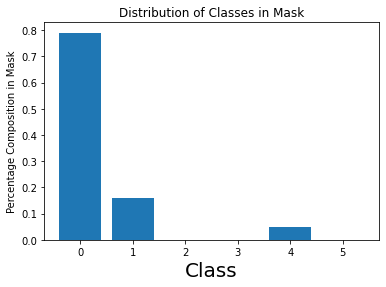



Class distribution histogram of mask: 004dd32d9cd167d9cc31c13b704498af_mask.tiff


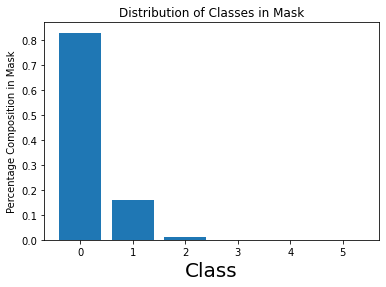



Class distribution histogram of mask: 0068d4c7529e34fd4c9da863ce01a161_mask.tiff


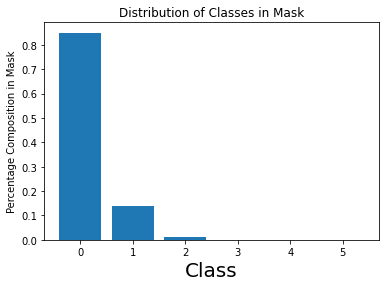



Class distribution histogram of mask: 006f6aa35a78965c92fffd1fbd53a058_mask.tiff


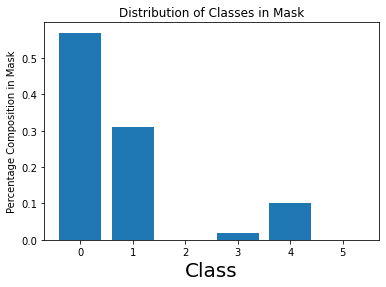



Class distribution histogram of mask: 007433133235efc27a39f11df6940829_mask.tiff


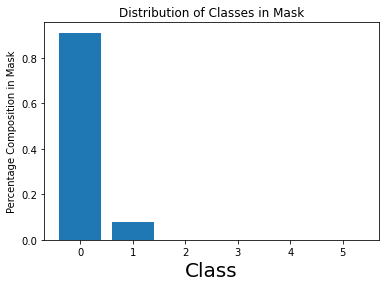



Class distribution histogram of mask: 0076bcb66e46fb485f5ba432b9a1fe8a_mask.tiff


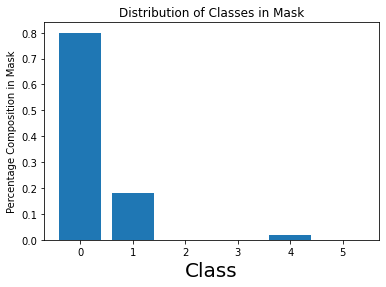



Class distribution histogram of mask: 008069b542b0439ed69b194674051964_mask.tiff


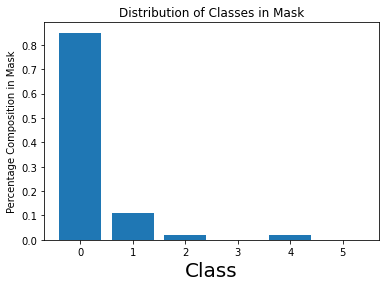



Class distribution histogram of mask: 00928370e2dfeb8a507667ef1d4efcbb_mask.tiff


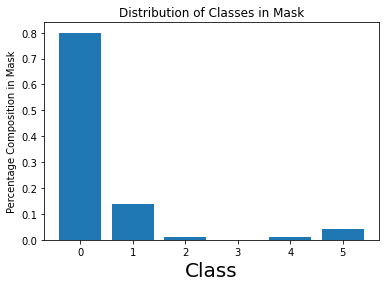



Class distribution histogram of mask: 00951a7fad040bf7e90f32e81fc0746f_mask.tiff


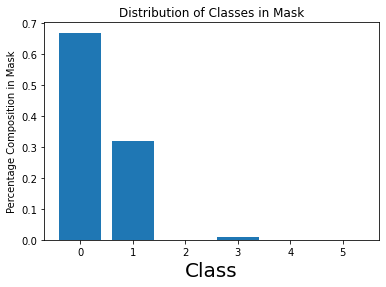



Class distribution histogram of mask: 00a26aaa82c959624d90dfb69fcf259c_mask.tiff


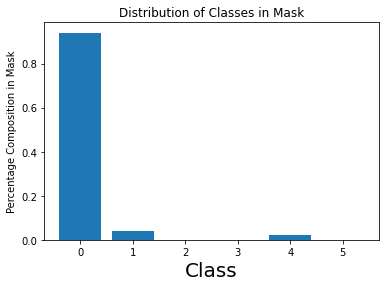

In [62]:
for mask_file in mask_files:
    mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_file))
    class_dict = summarize_class_distribution(mask)
    print(f"Class distribution histogram of mask: {mask_file}")
    dict_to_histogram(class_dict)
    print("\n")

## 12. Find the coordinates of the different classes in the mask

In [63]:
def get_class_coordinates(mask: np.ndarray,
                          channel_idx: int = 0) -> Dict[int, List[tuple[int]]]:
    """
    For each class label (integer index) present in 
    the mask, get a list of all its coordinates in the
    format of a dictionary that maps the class label to 
    the list of coordinates in mask where it is present
    
    Parameters:
    -----------
    mask: np.ndarray
        Input mask
    
    channel_idx: int (default = 0)
        In case of a three-channel mask, the channel id
        that can be used as the official mask
    
    Returns:
    --------
    Dict:
        A dictionary mapping each class label to a list of 
        its coordinates
    """
    
    if len(mask.shape) == 3 and mask.shape[2] == 3:
        mask = mask[:, :, channel_idx]
    
    assert len(mask.shape) == 2
    
    avail_classes = np.unique(mask)
    coord_dict = dict()
    
    for c in avail_classes:
        coords = np.where(mask == c)
        assert len(coords) == 2
        coord_dict[c] = [(i, j) for (i, j) in zip(coords[0], coords[1])]
    
    return coord_dict

In [26]:
mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_files[0]))
coord_dict = get_class_coordinates(mask = mask)

In [63]:
for k in coord_dict.keys():
    print(f"Class Label: {k}")
    print(coord_dict[k][0:5])
    print("\n")

Class Label: 0
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]


Class Label: 1
[(1618, 2470), (1618, 2471), (1618, 2472), (1618, 2473), (1618, 2474)]


Class Label: 2
[(3676, 4378), (3676, 4379), (3676, 4380), (3676, 4381), (3676, 4382)]


Class Label: 4
[(2694, 3462), (2694, 3463), (2695, 3462), (2695, 3463), (2696, 3462)]




## 10. Visualize random, signal-rich tiles of the images and their corresponding class distributions

In [136]:
id_to_class = {0: "background (non tissue) or unknown",
               1: "stroma (connective tissue, non-epithelium tissue)",
               2: "healthy (benign) epithelium",
               3: "cancerous epithelium (Gleason 3)",
               4: "cancerous epithelium (Gleason 4)",
               5: "cancerous epithelium (Gleason 5)"}

In [145]:
def plot_tile_by_first_class_occurance(image: np.ndarray,
                                       mask: np.ndarray,
                                       tile_size: int = 224,
                                       pivot_class: int = 0,
                                       channel_idx: int = 0):
    
    if len(mask.shape) == 3 and mask.shape[2] == 3:
        mask = mask[:, :, channel_idx]
        
    assert len(mask.shape) == 2
    
    coords = np.where(mask == pivot_class)
    
    x = coords[0][0]
    y = coords[1][0]
    
    tile_image = image[x: x + tile_size, y: y + tile_size]
    tile_mask = mask[x: x + tile_size, y: y + tile_size]
    
    class_dict = summarize_class_distribution(tile_mask)
    dict_to_histogram(class_dict)
    
    plt.imshow(tile_image)
    
    
    for k in class_dict.keys():
        print(f"Percentage of {k}, {id_to_class[k]}: {class_dict[k]}")

In [143]:
mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_files[0]))
image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_files[0]))

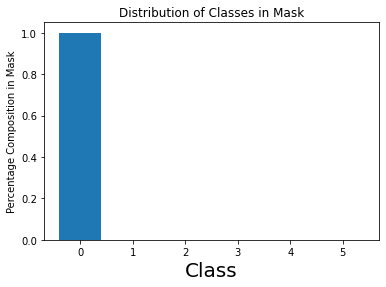

Percentage of 0, background (non tissue) or unknown: 1.0
Percentage of 1, stroma (connective tissue, non-epithelium tissue): 0.0
Percentage of 2, healthy (benign) epithelium: 0.0
Percentage of 3, cancerous epithelium (Gleason 3): 0.0
Percentage of 4, cancerous epithelium (Gleason 4): 0.0
Percentage of 5, cancerous epithelium (Gleason 5): 0.0


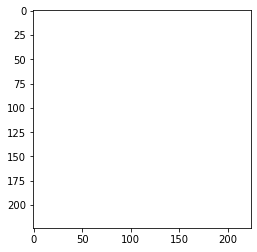

In [146]:
plot_tile_by_first_class_occurance(image = image,
                                   mask = mask,
                                   pivot_class = 0)

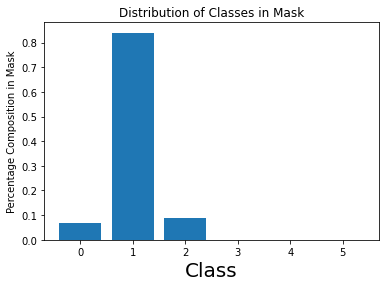

Percentage of 0, background (non tissue) or unknown: 0.07
Percentage of 1, stroma (connective tissue, non-epithelium tissue): 0.84
Percentage of 2, healthy (benign) epithelium: 0.09
Percentage of 3, cancerous epithelium (Gleason 3): 0.0
Percentage of 4, cancerous epithelium (Gleason 4): 0.0
Percentage of 5, cancerous epithelium (Gleason 5): 0.0


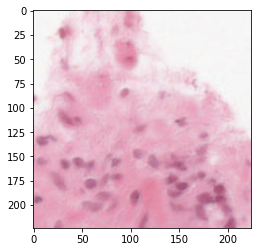

In [147]:
plot_tile_by_first_class_occurance(image = image,
                                   mask = mask,
                                   pivot_class = 1)

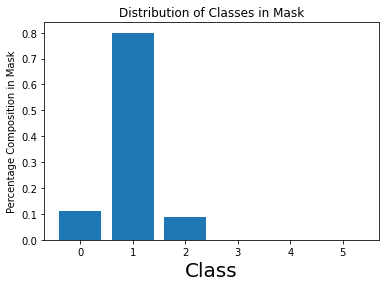

Percentage of 0, background (non tissue) or unknown: 0.11
Percentage of 1, stroma (connective tissue, non-epithelium tissue): 0.8
Percentage of 2, healthy (benign) epithelium: 0.09
Percentage of 3, cancerous epithelium (Gleason 3): 0.0
Percentage of 4, cancerous epithelium (Gleason 4): 0.0
Percentage of 5, cancerous epithelium (Gleason 5): 0.0


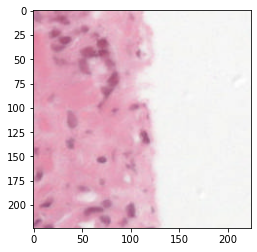

In [148]:
plot_tile_by_first_class_occurance(image = image,
                                   mask = mask,
                                   pivot_class = 2)

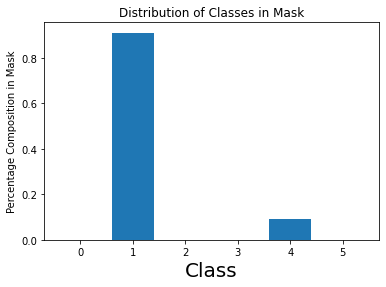

Percentage of 1, stroma (connective tissue, non-epithelium tissue): 0.91
Percentage of 4, cancerous epithelium (Gleason 4): 0.09
Percentage of 0, background (non tissue) or unknown: 0.0
Percentage of 2, healthy (benign) epithelium: 0.0
Percentage of 3, cancerous epithelium (Gleason 3): 0.0
Percentage of 5, cancerous epithelium (Gleason 5): 0.0


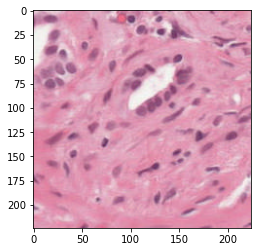

In [150]:
plot_tile_by_first_class_occurance(image = image,
                                   mask = mask,
                                   pivot_class = 4)

In [151]:
mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_files[8]))
image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_files[8]))

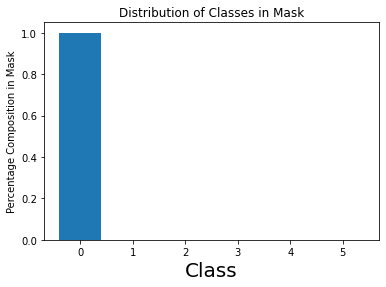

Percentage of 0, background (non tissue) or unknown: 1.0
Percentage of 1, stroma (connective tissue, non-epithelium tissue): 0.0
Percentage of 2, healthy (benign) epithelium: 0.0
Percentage of 3, cancerous epithelium (Gleason 3): 0.0
Percentage of 4, cancerous epithelium (Gleason 4): 0.0
Percentage of 5, cancerous epithelium (Gleason 5): 0.0


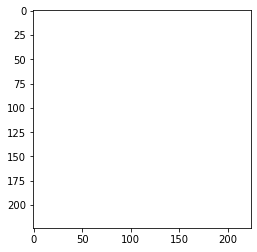

In [152]:
plot_tile_by_first_class_occurance(image = image,
                                   mask = mask,
                                   pivot_class = 0)

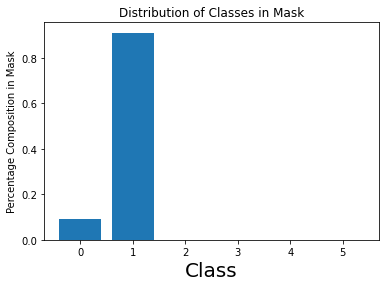

Percentage of 0, background (non tissue) or unknown: 0.09
Percentage of 1, stroma (connective tissue, non-epithelium tissue): 0.91
Percentage of 2, healthy (benign) epithelium: 0.0
Percentage of 3, cancerous epithelium (Gleason 3): 0.0
Percentage of 4, cancerous epithelium (Gleason 4): 0.0
Percentage of 5, cancerous epithelium (Gleason 5): 0.0


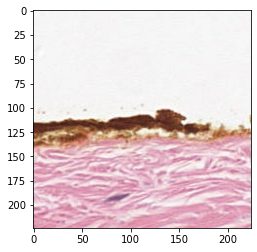

In [153]:
plot_tile_by_first_class_occurance(image = image,
                                   mask = mask,
                                   pivot_class = 1)

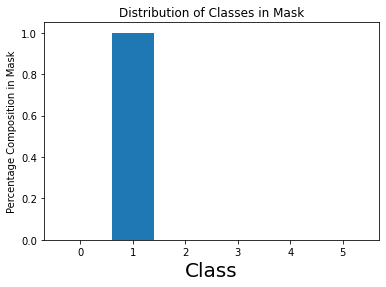

Percentage of 1, stroma (connective tissue, non-epithelium tissue): 1.0
Percentage of 2, healthy (benign) epithelium: 0.0
Percentage of 0, background (non tissue) or unknown: 0.0
Percentage of 3, cancerous epithelium (Gleason 3): 0.0
Percentage of 4, cancerous epithelium (Gleason 4): 0.0
Percentage of 5, cancerous epithelium (Gleason 5): 0.0


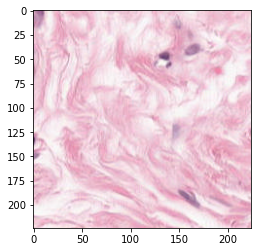

In [154]:
plot_tile_by_first_class_occurance(image = image,
                                   mask = mask,
                                   pivot_class = 2)

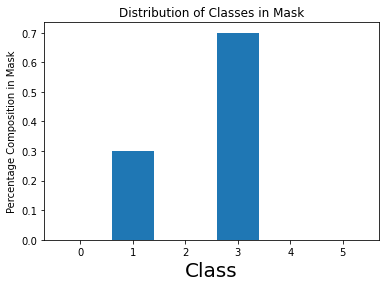

Percentage of 1, stroma (connective tissue, non-epithelium tissue): 0.3
Percentage of 3, cancerous epithelium (Gleason 3): 0.7
Percentage of 0, background (non tissue) or unknown: 0.0
Percentage of 2, healthy (benign) epithelium: 0.0
Percentage of 4, cancerous epithelium (Gleason 4): 0.0
Percentage of 5, cancerous epithelium (Gleason 5): 0.0


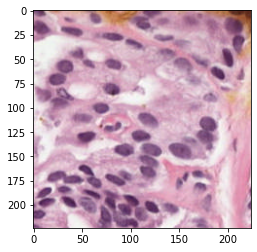

In [155]:
plot_tile_by_first_class_occurance(image = image,
                                   mask = mask,
                                   pivot_class = 3)

In [181]:
mask = tifffile.imread(os.path.join(ROOT_FOLDER, MASK_SUBFOLDER, mask_files[5]))
image = tifffile.imread(os.path.join(ROOT_FOLDER, IMAGE_SUBFOLDER, image_files[5]))

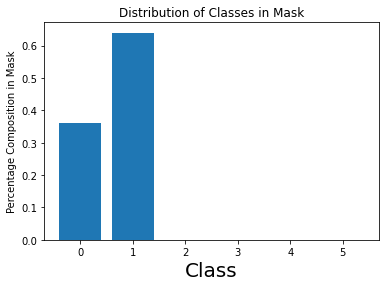

Percentage of 0, background (non tissue) or unknown: 0.36
Percentage of 1, stroma (connective tissue, non-epithelium tissue): 0.64
Percentage of 2, healthy (benign) epithelium: 0.0
Percentage of 3, cancerous epithelium (Gleason 3): 0.0
Percentage of 4, cancerous epithelium (Gleason 4): 0.0
Percentage of 5, cancerous epithelium (Gleason 5): 0.0


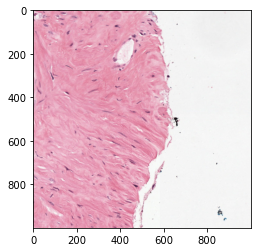

In [182]:
plot_tile_by_first_class_occurance(image = image,
                                   mask = mask,
                                   pivot_class = 3,
                                   tile_size = 1000)

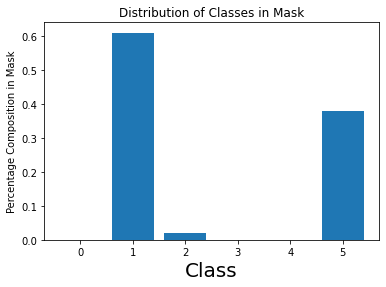

Percentage of 1, stroma (connective tissue, non-epithelium tissue): 0.61
Percentage of 2, healthy (benign) epithelium: 0.02
Percentage of 5, cancerous epithelium (Gleason 5): 0.38
Percentage of 0, background (non tissue) or unknown: 0.0
Percentage of 3, cancerous epithelium (Gleason 3): 0.0
Percentage of 4, cancerous epithelium (Gleason 4): 0.0


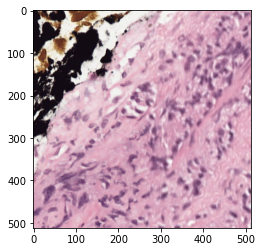

In [169]:
plot_tile_by_first_class_occurance(image = image,
                                   mask = mask,
                                   pivot_class = 2,
                                   tile_size = 512)

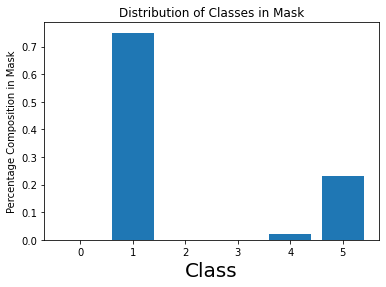

Percentage of 1, stroma (connective tissue, non-epithelium tissue): 0.75
Percentage of 4, cancerous epithelium (Gleason 4): 0.02
Percentage of 5, cancerous epithelium (Gleason 5): 0.23
Percentage of 0, background (non tissue) or unknown: 0.0
Percentage of 2, healthy (benign) epithelium: 0.0
Percentage of 3, cancerous epithelium (Gleason 3): 0.0


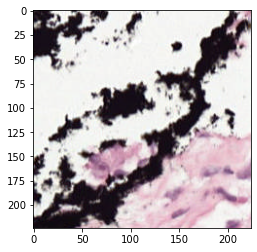

In [165]:
plot_tile_by_first_class_occurance(image = image,
                                   mask = mask,
                                   pivot_class = 4,
                                   tile_size = 224)